# IRWA Final Project 

This project aims to build a search engine implementing different indexing and ranking algorithms. This will be done using a file containing a set of tweets from the World Health Organization (@WHO).

It will be divided in four parts:

    1) Text processing
    2) Indexing and evaluation
    3) Ranking 
    4) User Interface and Web analytics


Students Group 9:
- Mireia Beltran (U161808)
- Cisco Orteu (U162354)
- Laura Casanovas (U161832)

#### Packages

We first import all the packages needed for text processing. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from scipy.special import logsumexp

In [4]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
from gensim.models.word2vec import Word2Vec
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [5]:
# if you do not have 'nltk', the following command should work "python -m pip install nltk"
import nltk
nltk.download('stopwords')
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import json
import regex as re 
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mire2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Load data into memory

The dataset is stored in a txt file ```dataset_tweets_WHO.txt```and it contains a set of tweets in json format. We create tweets_data by using json.loads() function, which from a JSON string it can be parsed and it returns the content of the file.

In [6]:
text = open('dataset_tweets_WHO.txt', 'r')

In [7]:
tweets_data=[]
for line in text:
    tweet=json.loads(line)
    tweets_data.append(tweet)
text.close()

#### Dataset Creation

In order to read and process each tweet, we create a dictionary in which we will have just one row, and each column will contain one tweet

In [8]:
import pandas as pd

# Build DataFrame of tweet texts and languages
df = pd.DataFrame(tweets_data)

We now create a new variable called 'texts' which will contain in each position of the array a tweet. Below this cell we print as an example the content of the first position of the array

In [9]:
texts=[]
for i in df:
    line =  df[i].item()['full_text']
    texts.append(str(line))

In [10]:
texts[0]

"It's International Day for Disaster Risk Reduction\n\n#OpenWHO has launched a multi-tiered core curriculum to help equip you with the competencies needed to work within public health emergency response.\n\nStart learning today &amp; be #Ready4Response:\n👉 https://t.co/hBFFOF0xKL https://t.co/fgZY22RWuS"

## 1) Text Processing

We implement the function ```build_terms(text)```.

It takes as input a text and performs the following operations:

- Stem terms
- Remove stop words
- Remove punctuation 
- Remove links
- Remove emojis
- Transform all text to lowercase
- Tokenize the text to get a list of terms

(We decided not to remove hashtags since it may be interesting to treat them separately later)

In [11]:
def build_terms(text):
    """
    Preprocess the article text (title + body) removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    text -- string (text) to be preprocessed
    
    Returns:
    text - a list of tokens corresponding to the input text after the preprocessing
    """
    # create the pattern
    stemmer = PorterStemmer()
    
    stop_words = set(stopwords.words("english"))
    remove = string.punctuation
    remove = remove.replace("#", "–")# don't remove hashtags
    remove = remove+'¿'
    pattern = r"[{}]".format(remove) # create the pattern
    text = re.sub(pattern, "", text)
    text = re.sub(r'http\S+', '', text)
    
    #compile a regular expression pattern into a regular expression object
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    #Return the string obtained by replacing the leftmost non-overlapping occurrences of pattern in string by the replacement
    text = emoji_pattern.sub(r'', text) # no emoji
    
    # Transform in lowercase
    text=  str.lower(text) 
    # Tokenize the text to get a list of terms
    text=  text.split() 
    # Eliminate the stopwords
    text=[l for l in text if l not in stop_words] 
    

    # Perform stemming 
    text=[stemmer.stem(word) for word in text]
    
    return text

In [12]:
texts_processed = []
for i in range(len(texts)):
    texts_processed.append(build_terms(texts[i]))
    

# 2) Indexing and evaluation

To create the index we use the function ```create_index(text)```. 

In [13]:
def create_index(texts, num_documents):
    """
    Implement the inverted index
    
    Argument:
    lines -- collection of Wikipedia articles
    
    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of documents where these keys appears in (and the positions) as values.
    idf,tf,df
    """
    index = defaultdict(list)
    tf = defaultdict(list)  #term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  #document frequencies of terms in the corpus
    title_index = {}  # dictionary to map page titles to page ids
    idf = defaultdict(float)
    tweet_id = 0
    for text in texts:  # Remember, lines contain all documents
        terms = build_terms(text) #page_title + page_text
        tweet_id += 1
        title_index[tweet_id]=text  
        
        
        doc_freq = {i:terms.count(i) for i in terms}
        current_page_index = {}
        
        for position, term in enumerate(terms): # terms contains page_title + page_text. Loop over all terms
            
            try:
                # if the term is already in the index for the current page (current_page_index)
                # append the position to the corresponding list
                

                current_page_index[term][1].append(position)  
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term] = [tweet_id, array('I',[position])] #'I' indicates unsigned int (int in Python)
        
        norm = 0
        for term, posting in current_page_index.items():
            # posting will contain the list of positions for current term in current document. 
            # posting ==> [current_doc, [list of positions]] 
            # you can use it to infer the frequency of current term.
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)
            

        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_page_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm,4)) ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] +=1 # increment DF for current term

        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(num_documents/df[term])), 4)

    return index, tf, df, idf, title_index

In [14]:
import time
start_time = time.time()
index, tf, df, idf, title_index = create_index(texts, len(texts))
print("Total time to create the index: {} seconds".format(np.round(time.time() - start_time, 2)))

Total time to create the index: 299.91 seconds


Here we have an example of the index of the word researcher:

In [15]:
print("Index results for the term 'researcher': {}\n".format(index['researcher']))
print("First 10 Index results for the term 'research': \n{}".format(index['research'][:10]))

Index results for the term 'researcher': []

First 10 Index results for the term 'research': 
[[23, array('I', [16])], [154, array('I', [22])], [172, array('I', [17])], [204, array('I', [5])], [211, array('I', [8])], [212, array('I', [5])], [222, array('I', [6])], [423, array('I', [12])], [429, array('I', [4])], [460, array('I', [23])]]


We start with the evaluation

In [16]:
def rank_documents(terms, docs, index, idf, tf, title_index):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title
    
    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    #HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex]=query_terms_count[term]/query_norm * idf[term] 

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each doc 
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot
    
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search(query, index)
    #print ('\n'.join(result_docs), '\n')
    return result_docs, doc_scores

In [17]:
def search(query, index):
    """
    The output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
    ## START DODE
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs=[posting[0] for posting in index[term]]
            # docs = docs intersection term_docs
            if len(docs)==0:
                docs |= set(term_docs)
            else:
                docs = docs.intersection(set(term_docs))
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs, scores = rank_documents(query, docs, index, idf, tf, title_index)
    return ranked_docs, scores

To decide which queries we will pass to our algorithm:

In [18]:
#for the queries
top_10 = {}
for i in index:
    top_10[i]=len(index[i])
top_10 = dict(sorted(top_10.items(), reverse=True, key=lambda item: item[1]))

In [19]:
queries = ['global pandemic', 'world disease', 'emergency call','countries risk', 'vaccine covid19']
relevant_docs=[]
scores_docs=[]
for i in queries:
    docs,scores = search(i, index)
    top = 10

    print("\n======================\nSample of {} results out of {} for the query '", i,"'\n".format(top, len(docs)))
    for d_id in docs[:top]:
        print("tweet_id= {} - tweet: {}\n".format(d_id, title_index[d_id]))
        
    relevant_docs.append(docs[:top])
    scores_docs.append(scores[:top])


Sample of {} results out of {} for the query ' global pandemic '

tweet_id= 1006 - tweet: @DrTedros "But the lessons from West Africa were not sufficient to prepare the world for a global pandemic of a respiratory pathogen"-@DrTedros https://t.co/BIB3WZmPep

tweet_id= 517 - tweet: Global leaders attending the 🇺🇸-hosted Global #COVID19 Summit re-affirm their commitment to ending the acute phase of the pandemic, and the goals of the @ACTAccelerator, by agreeing targets to provide equitable access to:
✅tests
✅treatments
✅vaccines

👉https://t.co/T3utXY29Bv https://t.co/njtxVXEbs0

tweet_id= 1088 - tweet: "Most recently, the @g20org established a High-Level Independent Panel on Financing the Global Commons for Pandemic Preparedness and Response."-@DrTedros 
https://t.co/5U2cYU5mDm

tweet_id= 997 - tweet: @DrTedros "There have been several reviews of the global response to the #COVID19 pandemic, with recommendations for countries and for WHO about what we can do to keep the world safer in f

In [20]:
relevant_df = pd.DataFrame(index = title_index.keys(), columns= ['y_pred1','y_true1','y_pred2','y_true2','y_pred3','y_true3','y_pred4','y_true4','y_pred5','y_true5'])
columns_pred = ['y_pred1','y_pred2','y_pred3','y_pred4','y_pred5']
columns_true = ['y_true1','y_true2','y_true3','y_true4','y_true5']

relevant_df = relevant_df.fillna(0.0)

for i in range(len(columns_pred)):
    for j in range(len(scores_docs[i])):
        relevant_df[columns_pred[i]][scores_docs[i][j][1]] = scores_docs[i][j][0]

for q in range(len(queries)):
    query = build_terms(queries[q])
    word1=query[0]
    word2=query[1]
    for i in title_index.keys():
        if word1 in texts_processed[i-1] and word2 in texts_processed[i-1]:
            relevant_df[columns_true[q]][i]=1

relevant_df

,y_pred1,y_true1,y_pred2,y_true2,y_pred3,y_true3,y_pred4,y_true4,y_pred5,y_true5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


First we define all the functions for the different techniques:

In [21]:
def precision_at_k(y_pred, y_truee,k):
    '''    
    Parameters
    ----------
    y_true: Ground truth (true relevance labels)
    k : number of doc to consider.
    
    Returns
    -------
    precision @k : float
    
    ''' 
    ordered = relevant_df.sort_values(by=y_pred, ascending=False)
    y_true = ordered[y_truee][:k]
    relevant = sum(y_true==1)
    return relevant/len(relevant_df[relevant_df[y_pred]>0])

    """else:
        print('k is larger than the documents manually evaluated')
    """

In [22]:
def avg_precision_at_k(y_pred, y_truee, k):
    
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    k : number of doc to consider.
    
    Returns
    -------
    average precision @k : float
    '''
    ordered = relevant_df.sort_values(by=y_pred, ascending=False)
    y_true = ordered[y_truee][:k]
    gtp = np.sum(y_true == 1)

    ## if all docs are not relevant
    if gtp==0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(y_true)):
        if y_true[y_true.index[i]] == 1:
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i+1)
    return prec_at_i/gtp

In [23]:
def map_at_k(avg_prec):
    return sum(avg_prec)/len(avg_prec)

In [24]:
def mrr_k():
    mrr=0
    for i in range(len(queries)):
        ordered = relevant_df.sort_values(by=columns_pred[i], ascending=False)
        rank=0
        for j in ordered[columns_pred[i]]:
            rank+=1
            if j>0:
                mrr+=1/(rank)
                break
    return mrr/len(queries)

In [25]:
def DCG(y_pred,y_true):
    relevants = relevant_df[relevant_df[y_pred]>0][y_true]
    DCG = pd.DataFrame(index = [i for i in range(1,len(relevants)+1)],columns= ['y_true','gain','DCG','DCG_ideal'])

    DCG['y_true'] = list(relevants)

    for i in range(len(DCG)):
        DCG['gain'][DCG.index[i]] = min(DCG['y_true'][DCG.index[i]] * 1/math.log(DCG.index[i],2),1)
    DCG['DCG'] = DCG['gain'].cumsum()

    for i in range(len(DCG)):
        DCG['DCG_ideal'][DCG.index[i]] = min(((2**DCG['y_true'][DCG.index[i]]) -1 ) / math.log(DCG.index[i],2),1)
    DCG['DCG_ideal'] = DCG['DCG_ideal'].cumsum()    
    DCG['NDCG'] = DCG['DCG']/DCG['DCG_ideal']
    return int(DCG['NDCG'][-1:])

In [26]:
precisionK = []
avg_precisionK = []
DCG_results = []

for i in range(len(columns_pred)):
    p = precision_at_k( columns_pred[i], columns_true[i], top)
    avg_p = avg_precision_at_k(columns_pred[i], columns_true[i], top)
    dcg = DCG(columns_pred[i], columns_true[i])
    precisionK.append(p)
    avg_precisionK.append(avg_p)
    DCG_results.append(dcg)
    
map_k=map_at_k(avg_precisionK)
mrr = mrr_k()
print('Precision:', precisionK)
print('Average precision:', avg_precisionK)
print('Mean average precision:',map_k)
print('Mean Reciprocal Rank:', mrr)
print('NDCG:', DCG_results)

Precision: [1.0, 1.0, 1.0, 1.0, 1.0]
Average precision: [1.0, 1.0, 1.0, 1.0, 1.0]
Mean average precision: 1.0
Mean Reciprocal Rank: 1.0
NDCG: [1, 1, 1, 1, 1]


In [27]:
#!pip install gensim==3.0
#!pip install tsne

Then we represent the tweets in a two-dimensional scatter plot through the t-sne algorithm

In [28]:
# Train a Word2Vec model
model = Word2Vec(texts_processed, min_count=1)
words = list(model.wv.vocab)

Slow version of gensim.models.word2vec is being used
under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


In [29]:
len(words)

5940

We do first the plot considering each word for the feature representation:

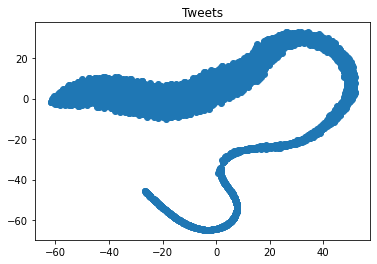

In [30]:
X = model[model.wv.vocab]
X_embedded = TSNE(2, 50,30).fit_transform(X)
Y=X_embedded
fig, ax = plt.subplots()
ax.plot(Y[:, 0], Y[:, 1], 'o')
ax.set_title('Tweets')
plt.show()


Now we use the feature vectors we obtained for all the words contained in a tweet in order to obtain the same representation but now for each tweet instead of each word

In [31]:
model_tweets=[]
for i in range(len(texts_processed)):
    try:
        array = model[texts_processed[i][0]].copy()
        for j in texts_processed[i]:
            array += model[j].copy()
        array = array/len(texts_processed[i])    
        model_tweets.append(array)
    except:
        continue
    

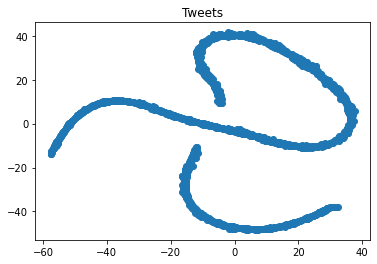

In [32]:
from sklearn.manifold import TSNE
X_embedded = TSNE(2, 50,30).fit_transform(model_tweets)
Y=X_embedded
fig, ax = plt.subplots()
ax.plot(Y[:, 0], Y[:, 1], 'o')
ax.set_title('Tweets')
plt.show()

# 3) Ranking

In this part we will create e a new score, using information regarding the popularity over the social network of the tweets

First, we create the dataframe of tweets

In [37]:
df2 = pd.DataFrame(tweets_data)

We retrieve the number of retweets and favourites of each tweet, and store it in two lists, in which every position represents a tweet:

In [38]:
retweets=[]
likes=[]
for i in df2:
    ret =  df2[i].item()['retweet_count']
    like =  df2[i].item()['favorite_count']
    retweets.append(ret)
    likes.append(like)

We normalize these two arrays:

In [39]:
likes = np.array(likes)
retweets = np.array(retweets)
likes = likes/np.linalg.norm(likes)
retweets = retweets/np.linalg.norm(retweets)

Now, we use the same ranking function as before, but now we replace the tf idf by our own algorithm for relevance. That is, we multiply the tf by the favourites and the retweets ponderated by a 25% and 75% respectively:

In [40]:
def rank_documents_modified(terms, docs, index, idf, tf, title_index):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title
    
    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    #HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex]=query_terms_count[term]/query_norm * idf[term] 

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26    
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * (0.75*retweets[doc_index]+0.25*likes[doc_index])  # TODO: check if multiply for idf

    # Calculate the score of each doc 
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot
    
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_modified(query, index)
    #print ('\n'.join(result_docs), '\n')
    return result_docs, doc_scores

In [41]:
def search_modified(query, index):
    """
    The output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
    ## START DODE
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs=[posting[0] for posting in index[term]]
            # docs = docs intersection term_docs
            if len(docs)==0:
                docs |= set(term_docs)
            else:
                docs = docs.intersection(set(term_docs))
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs, scores = rank_documents_modified(query, docs, index, idf, tf, title_index)
    return ranked_docs, scores

And this is the final ranking:

In [42]:
for i in queries:
    docs,scores = search_modified(i, index)
    top = 10

    print("\n======================\nSample of {} results out of {} for the query '", i,"'\n".format(top, len(docs)))
    for d_id in docs[:top]:
        print("tweet_id= {} - retweet= {} - likes= {} - tweet: {}\n".format(d_id, retweets[d_id], likes[d_id], title_index[d_id]))


Sample of {} results out of {} for the query ' global pandemic '

tweet_id= 984 - retweet= 0.0002351958083255468 - likes= 0.0027038341268312304 - tweet: @DrTedros @Chikwe_I @schwartlanderb @erna_solberg @NAkufoAddo @GlobalGoalsUN @ACTAccelerator "In October last year, I was honoured to speak to Chancellor Merkel, which is when we first discussed the idea for a new centre that would serve as a global platform to enhance global capacity for pandemic and epidemic intelligence"-@DrTedros https://t.co/p4qUYVCdFX

tweet_id= 997 - retweet= 0.00014473588204649035 - likes= 0.0021997294591169334 - tweet: @DrTedros "There have been several reviews of the global response to the #COVID19 pandemic, with recommendations for countries and for WHO about what we can do to keep the world safer in future"-@DrTedros

tweet_id= 2111 - retweet= 0.0005246675724185274 - likes= 0.002932972612155911 - tweet: @DrTedros @G20 "We’re making scientific breakthroughs in global trials, but the impact is limited if we 

Now we will return a top-20 list of documents for each of the 5 queries, using word2vec + cosine similarity. We will use the tweet2vec and query2vec representation, as we explained in the report. Moreover, we have included also the ponderation by the retweets and favorites of each tweet:

In [43]:
from operator import itemgetter
from numpy.linalg import norm


model_queries = []
for i in range(len(queries)):
    query = build_terms(queries[i])
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs=[posting[0] for posting in index[term]]
            # docs = docs intersection term_docs
            if len(docs)==0:
                docs |= set(term_docs)
            else:
                docs = docs.intersection(set(term_docs))
        except:
            #term is not in index
            pass
    docs = list(docs)
    word1 = model[query[0]]
    word2 = model[query[1]]
    query = (word1 + word2)/2
    query_dict={}
    for j in range(len(model_tweets)):
        if j+1 in docs:
            query_dict[j+1] =(np.dot(query, model_tweets[j])) * (0.75*retweets[j]+0.25*likes[j])
    query_dict = dict(sorted(query_dict.items(), key = itemgetter(1), reverse = True)[:20])
    model_queries.append(query_dict)

And these are the tweets' ids returned by our code:

In [56]:
for i in range(len(model_queries)):
    print('Query', queries[i] , ':')
    for j in model_queries[i]:
        print('Tweet', j, ' Score:', model_queries[i][j])
    print('\n')
    

Query global pandemic :
Tweet 1016  Score: 0.1354133122977616
Tweet 162  Score: 0.06089637517790678
Tweet 186  Score: 0.04483255474481037
Tweet 729  Score: 0.03892476928985969
Tweet 517  Score: 0.03375140066103285
Tweet 653  Score: 0.024951689848655277
Tweet 2260  Score: 0.02189672428052394
Tweet 1925  Score: 0.016342987202887408
Tweet 1143  Score: 0.016274910645249777
Tweet 141  Score: 0.015613135654880114
Tweet 2112  Score: 0.015392851806994854
Tweet 1974  Score: 0.01481886023866306
Tweet 2111  Score: 0.012870902839387263
Tweet 1796  Score: 0.011548001539544984
Tweet 318  Score: 0.010190159903207712
Tweet 984  Score: 0.009125544967877555
Tweet 997  Score: 0.00882928049621243
Tweet 1900  Score: 0.008801834665978593
Tweet 452  Score: 0.00866231727215341
Tweet 2198  Score: 0.008308103027598586


Query world disease :
Tweet 2274  Score: 0.08044365535769477
Tweet 1178  Score: 0.02072871965951943
Tweet 320  Score: 0.019561251180783477
Tweet 1644  Score: 0.01559233955885457
Tweet 1774  Scor